# Atmospherically Corrected Earth Engine Time Series 

### Overview

This notebook creates atmospherically corrected time series of satellite imagery using [Google Earth Engine](https://earthengine.google.com/) and the [6S emulator](https://github.com/samsammurphy/6S_emulator). 

### Supported missions

* Sentintel2
* Landsat8
* Landsat7
* Landsat5
* Landsat4

### Output

Average, cloud-*free* pixel values 

### Cloud masking

Uses standard cloud masks, i.e. FMASK for Landsat and ESA-QA60 for Sentinel 2.  There is no guarantee they will find all clouds, a discussion on more advance and/or alternative cloud masking strategies is available [here](https://groups.google.com/forum/#!searchin/google-earth-engine-developers/cloud$20AND$20sentinel2%7Csort:relevance/google-earth-engine-developers/i63DS-Dg8Sg/FWenONUFBwAJ)

#### Initialize

In [2]:
# standard modules
import os
import sys
import ee
import matplotlib
import pandas as pd
%matplotlib inline
ee.Initialize()

# custom modules
base_dir = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(base_dir,'atmcorr'))
from kml_reader import read_kml
from timeSeries import timeSeries
from postProcessing import postProcessing
from plots import *

In [3]:
#debuggin
%load_ext autoreload
%autoreload 2

### User Input

In [4]:
target = 'Ruapehu'

# geometry
geom = read_kml('IAVCEI.kml', target)

# start and end of time series
startDate = '1985-01-01'# YYYY-MM-DD
stopDate  = '2017-01-01'# YYYY-MM-DD

# satellite missions
missions = ['Landsat4']#['Sentinel2', 'Landsat8', 'Landsat7', 'Landsat5', 'Landsat4']

### Google Earth Engine TimeSeries

We need to extract data from Earth Engine so that we can process it locally. The following code gets the mean average radiance through time from inside the geometry defined above. 

It also grabs the inputs required for atmospheric correction (e.g. aerosol optical thickness, water vapor, etc.).

Clouds are masked by default.

* mean radiance extractor invocation (all missions)

* try getInfo()

* except extract to csv and print instructions

#### Earth Engine Requests
Let's set up some requests for Earth Engine data.

In [40]:
from ee_requests import request_meanRadiance

requests = {}

for mission in missions:
    requests[mission] = request_meanRadiance(geom, 
                                             ee.Date(startDate), \
                                             ee.Date(stopDate), \
                                             mission, \
                                             True)

There are two methods for  accessing this data locally.

1. getInfo 
2. export 

The **getInfo()** option requires less steps so we try that first. The **export** option can handle larger requests (it is our backup plan).

In [43]:
try:# getInfo()

    data = []

    for mission in missions:
        localData = requests[mission].getInfo()
        data.append(localData['features'])
        
    # flatten separate mission lists into a single list
    data = [item for sublist in data for item in sublist]
        
except:# export
    
    pass
    
    # method 2: export
    
    # insert export here

In [44]:
fc = requests

### All time series
This function extracts cloud-free time series for each mission, atmospherically corrects them and joins them together

In [43]:
allTimeSeries = timeSeries(target, geom, startDate, stopDate, missions)

Loading from excel file


### Data post-processing
Resample into daily intervals using liner interpolation and calculate hue-saturation-value from RGB.

In [44]:
from postProcessing import postProcessing
data = postProcessing(allTimeSeries)

### bringing it all together...
make a pretty graph to help us do some science.

In [45]:
from plots import *
t1 = pd.datetime.strptime('2005-01-01','%Y-%m-%d')
t2  = pd.datetime.strptime('2017-01-01','%Y-%m-%d')

In [46]:
fieldData = load_fieldData(target, startDate, stopDate)

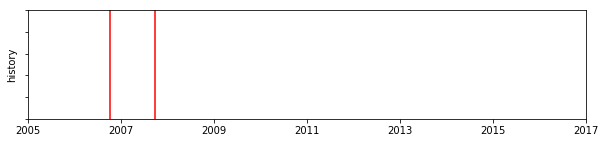

In [54]:
from plots import *
save = True
# save = False
plot_history(target, fieldData, t1, t2, save=save)

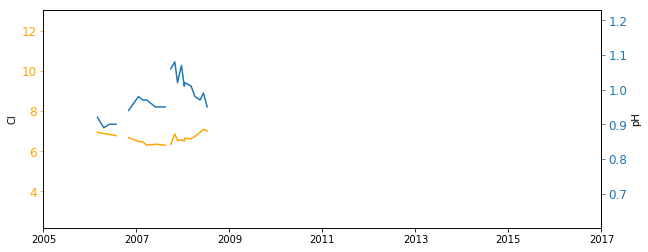

In [48]:
plot_acid(target, fieldData, t1, t2, save=save)

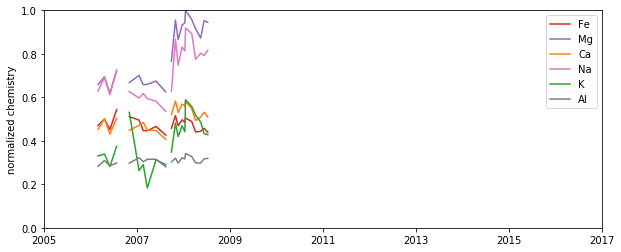

In [49]:
plot_other(target, fieldData, t1, t2, save=save)

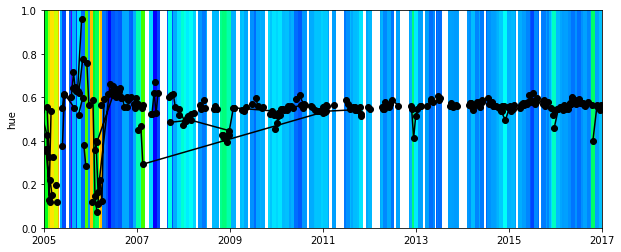

In [50]:
plot_hueSticks(target, data, t1, t2, save=save)

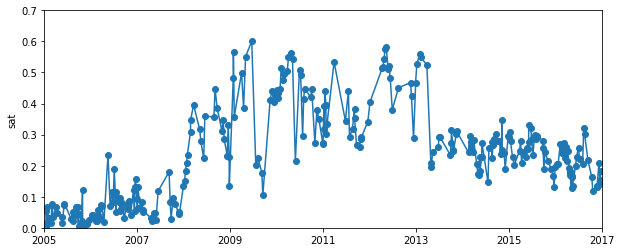

In [51]:
plot_color(target, data,'sat', t1, t2, fieldData, save=save)

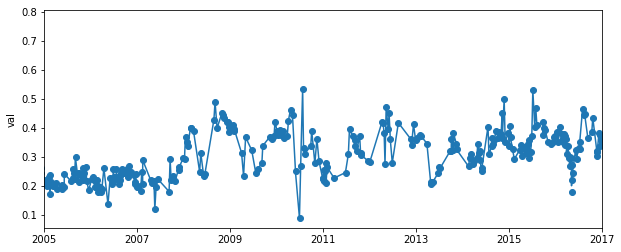

In [52]:
plot_color(target, data, 'val', t1, t2, fieldData, save=save)